#  Прогнозирование заказов такси

**Источник данных:** данные предоставлены заказчиком.

**Характер данных:** исторические данные о заказах такси в аэропортах.

**Цель заказчика:** привлечение большего числа водителей в период пиковой нагрузки.

**Задача исследования:** построение модели прогнозирования заказов такси на следующий час.

**Условия разработки:** метрика RMSE < 48.

---

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-окружения" data-toc-modified-id="Подготовка-окружения-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка окружения</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Ресемплирование" data-toc-modified-id="Ресемплирование-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Ресемплирование</a></span></li><li><span><a href="#Тренд-и-сезонность" data-toc-modified-id="Тренд-и-сезонность-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Тренд и сезонность</a></span></li><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Создание признаков</a></span></li><li><span><a href="#Разделение-на-выборки" data-toc-modified-id="Разделение-на-выборки-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Разделение на выборки</a></span></li><li><span><a href="#Масштабирование-признаков" data-toc-modified-id="Масштабирование-признаков-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Масштабирование признаков</a></span></li></ul></li><li><span><a href="#Подбор-модели" data-toc-modified-id="Подбор-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Подбор модели</a></span><ul class="toc-item"><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#DecisionTreeRegressor" data-toc-modified-id="DecisionTreeRegressor-4.1.2"><span class="toc-item-num">4.1.2&nbsp;&nbsp;</span>DecisionTreeRegressor</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-4.1.3"><span class="toc-item-num">4.1.3&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#KNeighborsRegressor" data-toc-modified-id="KNeighborsRegressor-4.1.4"><span class="toc-item-num">4.1.4&nbsp;&nbsp;</span>KNeighborsRegressor</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-4.1.5"><span class="toc-item-num">4.1.5&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-4.1.6"><span class="toc-item-num">4.1.6&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li></ul></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Анализ моделей</a></span></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Вменяемость-модели" data-toc-modified-id="Вменяемость-модели-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Вменяемость модели</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## Подготовка окружения

Установка дополнительных библиотек:

In [1]:
%%capture --no-stderr
!pip install lightgbm catboost

Импорт необходимыхх библиотек:

In [2]:
import pandas as pd
import numpy as np

import itertools
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split, \
                                    RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

Задание случайных величин:

In [3]:
SEED = 42
np.random.seed(SEED)

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## Загрузка данных

Выведение пяти первых строк набора данных для определения столбца индексов:

In [4]:
pd.read_csv('/datasets/taxi.csv').head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


Сохранение исходного набора данных с учётом столбца индексов и приведением его к формату дат `datetime64`:

In [5]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

Сортировка набора данных по столбцу индексов:

In [6]:
data.sort_index(inplace=True)

Выведение на экран первых пяти строк набора данных:

In [7]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Проверка хронологического порядка временного ряда:

In [8]:
print('Хронологический порядок соблюдён:', data.index.is_monotonic)

Хронологический порядок соблюдён: True


Выведение на экран размера набора данных:

In [9]:
print('Размер набора данных:', data.shape)

Размер набора данных: (26496, 1)


<div style="background-color: #EBF3FA; border-radius: 3px; padding: 20px;">

<strong>Вывод</strong>
    
* Данные соответствуют предоставленному описанию и представляют собой временной ряд.

</div>

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## Подготовка данных

Задание функции построения графика по значениям времянного ряда:

In [10]:
def plot_df(df: pd.DataFrame,
            title: str) -> None:
    
    df.plot(ax=plt.gca(), figsize=(8,6))
    plt.title(f'{title}\n', fontsize=16)
    
    plt.grid()
    plt.show()

Задание функции построения графика тренда и сезонности:

In [11]:
def plot_decomposed(df: pd.DataFrame) -> None:
    
    font_s=16
    plt.figure(figsize=(8,12))
    
    decomposed = seasonal_decompose(df)
    
    plt.subplot(311)
    decomposed.trend.plot(ax=plt.gca())
    plt.title('Тренд', fontsize=font_s)
    plt.grid()
    
    plt.subplot(312)
    decomposed.seasonal.plot(ax=plt.gca())
    plt.title('Сезонность', fontsize=font_s)
    plt.grid()
    
    plt.subplot(313)
    decomposed.resid.plot(ax=plt.gca())
    plt.title('Шум', fontsize=font_s)
    plt.grid()
    
    plt.tight_layout()
    plt.show()

---

### Анализ данных

Выведение на экран графика распределения данных:

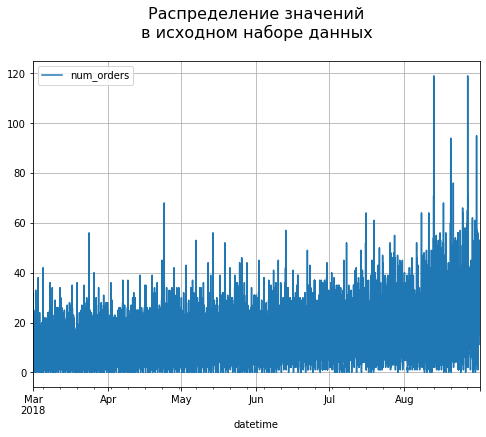

In [12]:
plot_df(data, 'Распределение значений\nв исходном наборе данных')

Выведение на экран значений месяцев, за которые предоставлены данные:

In [13]:
print('Данные предоставлены за', end=' ')
print(*data.index.month.unique(), sep=', ', end=' месяц(ы)')

Данные предоставлены за 3, 4, 5, 6, 7, 8 месяц(ы)

<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* Наблюдается тенденция учащения заказов к августу.
    
</div>

Выведение на экран значений годов, за которые предоставлены данные:

In [14]:
print('Данные предоставлены за', end=' ')
print(*data.index.year.unique(), sep=', ', end=' год(ы)')

Данные предоставлены за 2018 год(ы)

---

### Ресемплирование

Поскольку задача исследования заключается в прогнозировании значений столбца `num_orders` на следующий час, а данные собраны за каждые 10 минут, необходимо изменить интервал со значениями ряда набор данных на длину в один час.

Изменение интервала: 

In [15]:
data = data.resample('1H').sum()

Выведение на экран размера набора данных для проверки применённых изменений:

In [16]:
print('Размер набора данных:', data.shape)

Размер набора данных: (4416, 1)


Выведение на экран графика распределения данных для проверки применённых изменений:

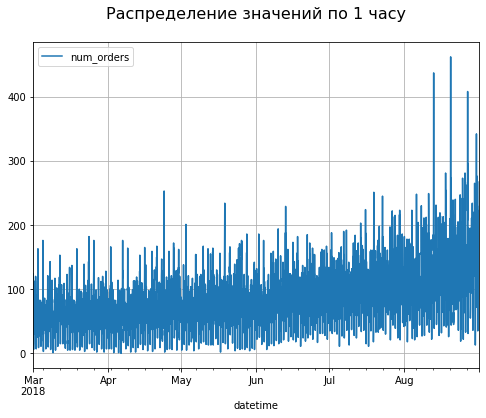

In [17]:
plot_df(data, 'Распределение значений по 1 часу')

<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* Временной ряд соответствует нестационарному стохастическому процессу — со временем его распределение меняется.
    
</div>

---

### Тренд и сезонность

Построение графика трендов и сезонности:

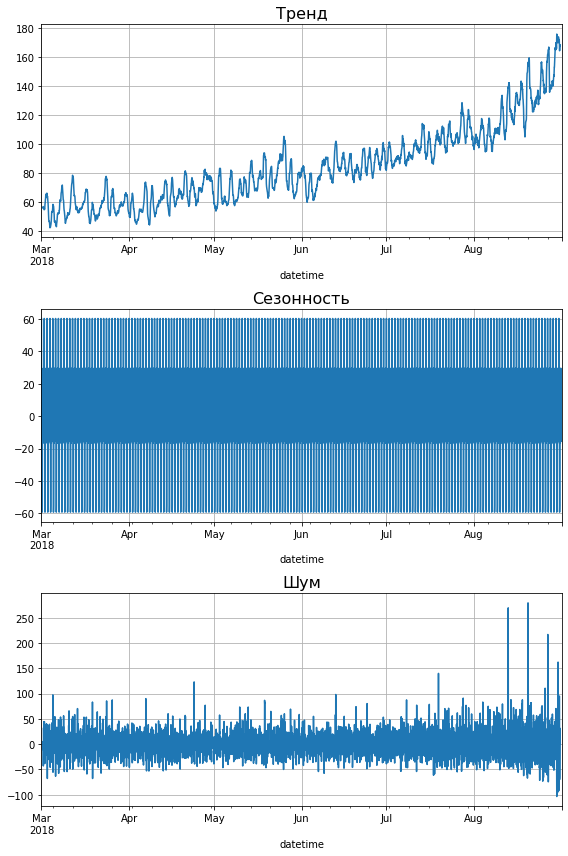

In [18]:
plot_decomposed(data)

<div style="background-color: #f9f9f9; border-radius: 2px; padding: 20px 20px 10px 20px;">
    
* Поскольку данные предоставлены только за один год, невозможно установить наличие трендов или сезонности.
    
</div>

---

### Создание признаков

Задание функции, формирующей новые признаки:

In [19]:
def make_features(df: pd.DataFrame, 
                  lag_max: int, 
                  rolling_window: int) -> pd.DataFrame:
    
    data = df.copy()
    
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, lag_max + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_window).mean()
    data['rolling_std'] = data['num_orders'].shift().rolling(rolling_window).std()
    
    data = data.dropna()
    
    return data

---

Согласно условию поставленной перед исследованием задачи скользящее среднее будет взято как двое суток, то есть 48 часов (как и для порога метрики RMSE на тестовой выборке), а в качестве разностей временного ряда будут взяты значения за сутки, то есть 24 часа.

Добавление признаков к исходному набору данных:

In [20]:
data_with_features = make_features(data, 24, 48)

Выведение на экран пяти первых строк преобразованного набора данных:

In [21]:
data_with_features.head()

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean,rolling_std
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-03 00:00:00,163,3,3,5,72.0,119.0,101.0,93.0,49.0,89.0,...,7.0,11.0,11.0,20.0,64.0,75.0,120.0,90.0,59.791667,30.918533
2018-03-03 01:00:00,108,3,3,5,163.0,72.0,119.0,101.0,93.0,49.0,...,46.0,7.0,11.0,11.0,20.0,64.0,75.0,120.0,60.604167,33.078720
2018-03-03 02:00:00,25,3,3,5,108.0,163.0,72.0,119.0,101.0,93.0,...,45.0,46.0,7.0,11.0,11.0,20.0,64.0,75.0,61.083333,33.602073
2018-03-03 03:00:00,64,3,3,5,25.0,108.0,163.0,72.0,119.0,101.0,...,54.0,45.0,46.0,7.0,11.0,11.0,20.0,64.0,60.125000,33.967209
2018-03-03 04:00:00,44,3,3,5,64.0,25.0,108.0,163.0,72.0,119.0,...,91.0,54.0,45.0,46.0,7.0,11.0,11.0,20.0,60.083333,33.961075


Выведение на экран графика распределения данных для проверки применённых изменений:

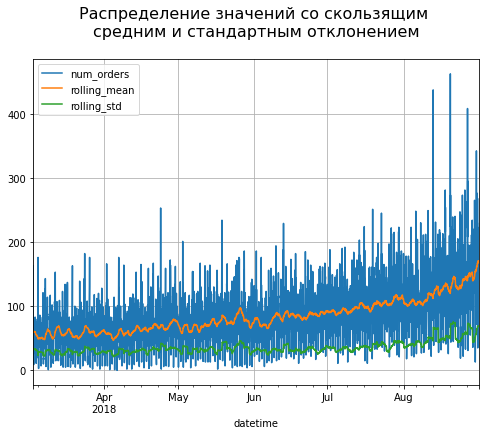

In [22]:
plot_df(data_with_features[['num_orders', 'rolling_mean', 'rolling_std']], 
        'Распределение значений со скользящим \nсредним и стандартным отклонением')

---

### Разделение на выборки

Разделение преобразованного набора данных на тренировочную и тестовую выборки:

In [23]:
train, test = train_test_split(data_with_features, shuffle=False, test_size=0.1)

Разделение тренировочной и тестовой выборок на признаки и целевой признак:

In [24]:
X_train, y_train = train.drop('num_orders', axis=1), train['num_orders']
X_test, y_test = test.drop('num_orders', axis=1), test['num_orders']

---

### Масштабирование признаков

Значения в столбцах признаков отличаются большим диапазоном, поэтому их необходимо масштабировать.

Задание объекта масштабирования:

In [25]:
scaler = StandardScaler()

Обучение объекта на тренировочной выборке:

In [26]:
scaler.fit(X_train)

StandardScaler()

Масштабирование тренировочной и тестовой выборок:

In [27]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Выведение на экран тренировочной выборки для проверки применённых изменений:

In [28]:
X_train_scaled

array([[-1.43790154e+00, -1.39617062e+00,  9.85304846e-01, ...,
         3.12582436e-01, -1.00546523e+00, -4.20186422e-01],
       [-1.43790154e+00, -1.39617062e+00,  9.85304846e-01, ...,
         1.10104193e+00, -9.60992000e-01, -5.70784407e-02],
       [-1.43790154e+00, -1.39617062e+00,  9.85304846e-01, ...,
        -8.16473106e-02, -9.34764200e-01,  3.08925341e-02],
       ...,
       [ 1.74510948e+00, -2.59537496e-01, -1.49785540e+00, ...,
         1.96834737e+00,  2.54555079e+00,  5.34056884e+00],
       [ 1.74510948e+00, -2.59537496e-01, -1.49785540e+00, ...,
         9.69632014e-01,  2.51134061e+00,  5.28339845e+00],
       [ 1.74510948e+00, -2.59537496e-01, -1.49785540e+00, ...,
        -2.80136121e-03,  2.54555079e+00,  5.30430049e+00]])

<div style="background-color: #EBF3FA; border-radius: 3px; padding: 20px;">

<strong>Вывод</strong>
    
* Исходные данные были подготовлены к построению моделей пронозирования.

</div>

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## Подбор модели

Поскольку поставленная перед исследованием задача заключается в решении задачи регрессии, для построения модели прогнозирования будут рассмотрены:

* `DecisionTreeRegression`

* `RandomForestRegressor`

* `KNeighborsRegressor`

* `LGBMRegressor`

* `CatBoostRegressor`

Задание словаря для сохранения результатов:

In [29]:
results = {}

---

Задание функции сохранения значений:

In [30]:
def save_results(name: str,
                 model,
                 params: dict,
                 score: float,
                 save_to: dict = results) -> dict:
    
    save_to[name] = {
        'model': model,
        'params': params,
        'score': score
    }

Задание функции поиска лучшей модели:

In [31]:
def search_model(estimator,
                 params: dict,
                 X_train: np.ndarray,
                 y_train: np.ndarray,
                 name: str,
                 n_splits: int = 3,
                 scoring: str = 'neg_mean_squared_error',
                 n_verbose: int = 0,
                 save_to: dict = results) -> None:
    
    print('Searching...')
    
    cv = TimeSeriesSplit(n_splits=n_splits)
    
    if params is None:
        raise ValueError('params should not be empty')
    
    if len(params) > 2:
        grid = RandomizedSearchCV(
            estimator, 
            params, 
            cv=cv, 
            scoring=scoring, 
            verbose=n_verbose
        )
    else:
        grid = GridSearchCV(
            estimator, 
            params, 
            cv=cv, 
            scoring=scoring, 
            verbose=n_verbose
        )

    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    best_params = grid.best_params_
    best_score = np.sqrt(-grid.best_score_)

    print(f'\nBest model params: {best_params}')
    print(f'Best RMSE: {best_score}')
    
    save_results(name, best_model, best_params, best_score, save_to)
    
    print('\nFinished\n')

---

### Обучение моделей

#### LinearRegression

Задание параметров модели:

In [32]:
params_lr = {
    'fit_intercept': [True, False]
}

Обучение модели:

In [33]:
%%time
search_model(LinearRegression(), params_lr, X_train_scaled, y_train, 'lin_reg')

Searching...

Best model params: {'fit_intercept': True}
Best RMSE: 28.102910491747423

Finished

CPU times: user 334 ms, sys: 917 ms, total: 1.25 s
Wall time: 1.23 s


---

#### DecisionTreeRegressor

Задание параметров модели:

In [34]:
params_dtr = {
    'splitter': ['best', 'random'],
    'max_depth': range(1, 20),
    'random_state': [SEED, None]
}

Обучение модели:

In [35]:
%%time
search_model(DecisionTreeRegressor(), params_dtr, X_train_scaled, y_train, 'dt_reg')

Searching...

Best model params: {'splitter': 'best', 'random_state': None, 'max_depth': 3}
Best RMSE: 33.75459485111269

Finished

CPU times: user 474 ms, sys: 70.9 ms, total: 545 ms
Wall time: 555 ms


---

#### RandomForestRegressor

Задание параметров модели:

In [36]:
params_rfr = {
    'n_estimators': range(100, 2000, 100),
    'max_depth': range(1, 20),
    'random_state': [SEED, None]
}

Обучение модели:

In [37]:
%%time
search_model(RandomForestRegressor(), params_rfr, X_train_scaled, y_train, 'rf_reg')

Searching...

Best model params: {'random_state': None, 'n_estimators': 300, 'max_depth': 15}
Best RMSE: 27.825260637493855

Finished

CPU times: user 11min 36s, sys: 1.15 s, total: 11min 38s
Wall time: 11min 38s


---

#### KNeighborsRegressor

Задание параметров модели:

In [38]:
params_knr = {
    'n_neighbors': range(1, 20),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}

Обучение модели:

In [39]:
%%time
search_model(KNeighborsRegressor(), params_knr, X_train_scaled, y_train, 'kn_reg')

Searching...

Best model params: {'weights': 'distance', 'p': 2, 'n_neighbors': 12, 'algorithm': 'ball_tree'}
Best RMSE: 28.499947012902023

Finished

CPU times: user 1.64 s, sys: 184 ms, total: 1.82 s
Wall time: 1.9 s


---

#### LGBMRegressor

Задание параметров модели:

In [40]:
params_lgbmr = {
    'n_estimators': range(100, 1000, 100),
    'max_depth': [-1, *range(1, 20)],
    'random_state': [SEED, None]
}

Обучение модели:

In [41]:
%%time
search_model(LGBMRegressor(), params_lgbmr, X_train_scaled, y_train, 'lgbm_reg')

Searching...

Best model params: {'random_state': None, 'n_estimators': 100, 'max_depth': 14}
Best RMSE: 27.70007034583824

Finished

CPU times: user 5min 16s, sys: 1.55 s, total: 5min 18s
Wall time: 5min 18s


---

#### CatBoostRegressor

Задание параметров модели:

In [42]:
params_cbr = {
    'n_estimators': range(100, 1000, 100),
    'max_depth': range(1, 16),
    'random_state': [SEED, None]
}

Обучение модели:

In [43]:
%%time
search_model(CatBoostRegressor(verbose=0), params_cbr, X_train_scaled, y_train, 'cb_reg')

Searching...

Best model params: {'random_state': 42, 'n_estimators': 600, 'max_depth': 7}
Best RMSE: 26.951234126930196

Finished

CPU times: user 35min 3s, sys: 2min 12s, total: 37min 15s
Wall time: 37min 41s


---

### Анализ моделей

Задание функции, конвертирующей словарь в датафрейм:

In [44]:
def convert_to_dataframe(results: dict) -> pd.DataFrame:
    
    return pd.DataFrame([val['score'] for val in results.values()], 
                        index=results.keys(),
                        columns=['score'])

Задание функции построения графика значений:

In [45]:
def plot_bar(df: pd.DataFrame,
             col_y: str,
             title: str,
             shift: float = 0.1) -> None:
    
    font_s = 12
    fig = plt.subplots(figsize=(16,5))

    plt.title(f'{title}\n', fontsize=font_s+4)
    
    labels = df.index
    x = range(len(labels))
    y = df[col_y]
    
    plt.bar(x, y)
    
    for i, val in enumerate(y):
        plt.text(i-shift,  val-7, str(round(val, 2)), fontsize=font_s+4, color='white')

    plt.xticks([i for i in x], labels)

    plt.xlabel('models', fontsize=font_s)
    plt.ylabel(col_y, fontsize=font_s)

    plt.grid()
    plt.plot()

---

Конвертация результатов в датафрейм:

In [46]:
data_results = convert_to_dataframe(results)

Выведение на экран результатов с сортировкой по значениям метрик:

In [47]:
data_results.sort_values('score')

,score
cb_reg,26.951234
lgbm_reg,27.700070
rf_reg,27.825261
lin_reg,28.102910
kn_reg,28.499947
dt_reg,33.754595


Построение графика значений метрик:

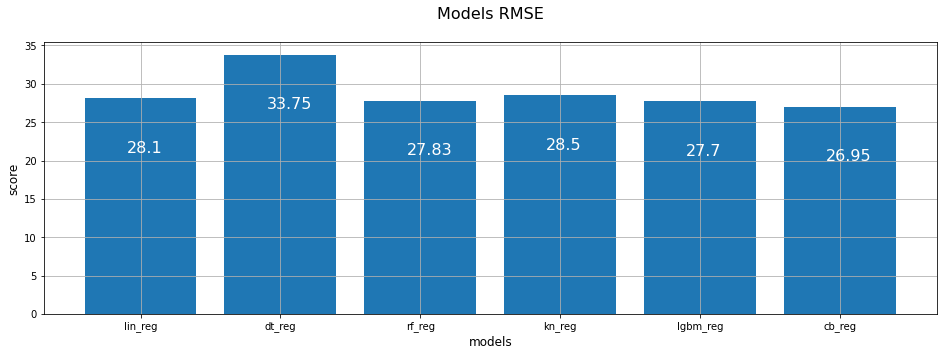

In [48]:
plot_bar(data_results, 'score', 'Models RMSE')

<div style="background-color: #EBF3FA; border-radius: 3px; padding: 20px;">

<strong>Вывод</strong>
    
* Лучший показатель метрики RMSE продемонстрировала модель `CatBoostRegressor`.

</div>

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## Тестирование модели

>В качестве порога метрики RMSE на тестовой выборке будет взято значение 48.

Задание функции, вычисляющей метрику RMSE:

In [49]:
def root_mean_squared_error(y_train: np.array,
                            y_pred: np.array) -> float:
    
    return mean_squared_error(y_train, y_pred, squared=False)

---

Задание модели:

In [50]:
model = results['cb_reg']['model']

Обчуение модели:

In [51]:
model.fit(X_train_scaled, y_train, verbose=0)

Получение предсказаний:

In [52]:
y_preds = model.predict(X_test_scaled)

Вычисление метрики:

In [53]:
model_score = root_mean_squared_error(y_test, y_preds)

Выведение на экран результата вычисления метрики:

In [54]:
print('RMSE Test:', model_score)
print('RMSE Train:', results['cb_reg']['score'])

RMSE Test: 41.326816900483244
RMSE Train: 26.951234126930196


Построение графика значений метрик:

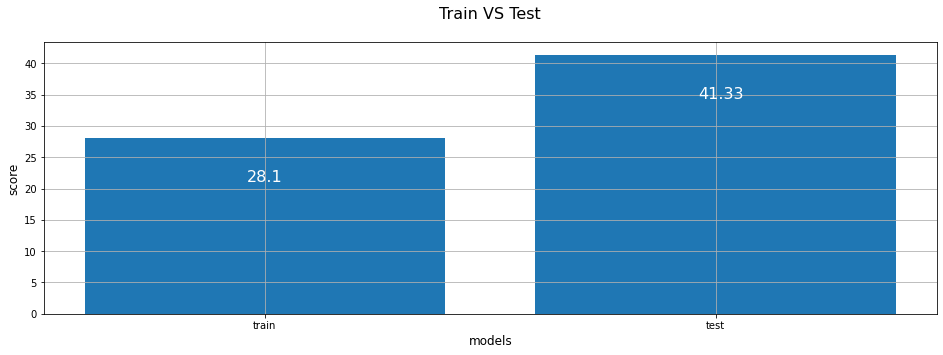

In [55]:
plot_bar(pd.DataFrame([results['lin_reg']['score'], model_score], 
                      columns=['score'],
                      index=['train', 'test']), 
         'score', 'Train VS Test', shift=0.04)

<div style="background-color: #EBF3FA; border-radius: 3px; padding: 20px;">

<strong>Вывод</strong>
    
* Модель продемонстрировала хороший результат метрики RMSE, не превышающий заявленного порога для тестовой выборки.

</div>

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## Вменяемость модели

Отобранную модель необходимо проверить на вменяемость посредством прогнозирования временного ряда без обучения с помощью: 

* Константного значения — все значения тестовой выборки прогнозируются одним и тем же числом.
* Предыдущего значения — все новые значения прогнозируются предыдущим значением ряда.

---

**Константное значение**

Задание константных значений по среднему арифметическому тренировочной выборки:

In [56]:
pred_mean = np.ones(test.shape) * train['num_orders'].mean()

Вычисление метрики:

In [57]:
const_score = root_mean_squared_error(test, pred_mean)

Выведение на экран метрик для сравнения результатов:

In [58]:
print('Среднее число заказов в час:', test['num_orders'].mean())
print(f'RMSE константной модели: {const_score}')
print(f'RMSE лучшей модели: {model_score}')

Среднее число заказов в час: 139.60411899313502
RMSE константной модели: 79.7655314063154
RMSE лучшей модели: 41.326816900483244


Построение графика значений метрик:

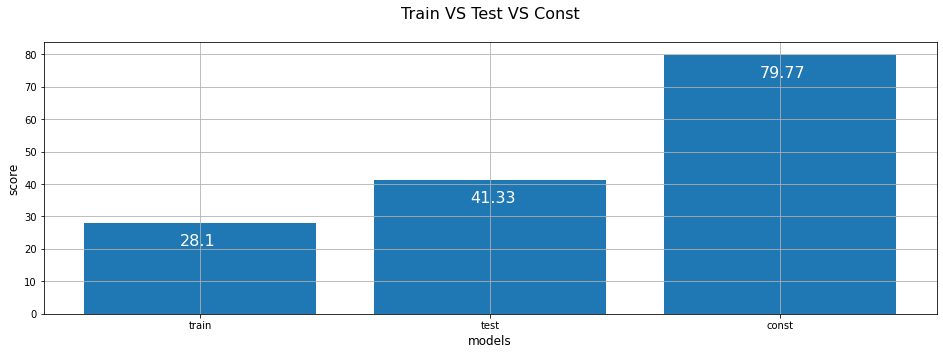

In [59]:
plot_bar(pd.DataFrame([results['lin_reg']['score'], model_score, const_score], 
                      columns=['score'],
                      index=['train', 'test', 'const']), 
         'score', 'Train VS Test VS Const', shift=0.07)

---

**Предыдущее значение**

Задание предыдущих значений:

In [60]:
pred_prev = test.shift()
pred_prev.iloc[0] = train.iloc[-1]

Вычисление метрики:

In [61]:
prev_score = root_mean_squared_error(test, pred_prev)

Выведение на экран метрик для сравнения результатов:

In [62]:
print('Среднее число заказов в час:', test['num_orders'].mean())
print(f'RMSE модели: {prev_score}')
print(f'RMSE лучшей модели: {model_score}')

Среднее число заказов в час: 139.60411899313502
RMSE модели: 49.53939423391295
RMSE лучшей модели: 41.326816900483244


Построение графика значений метрик:

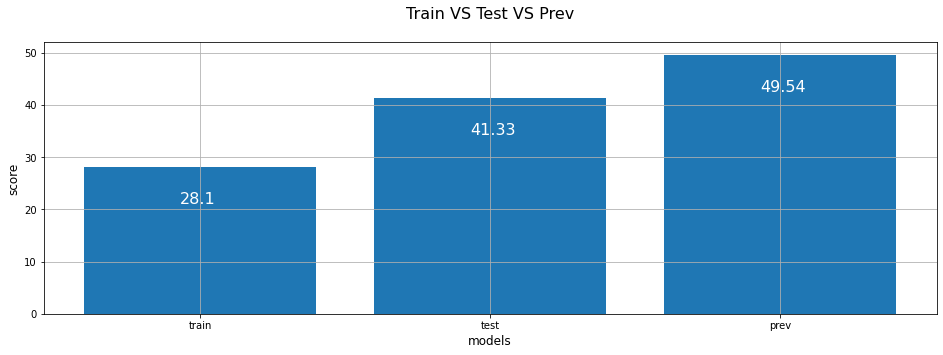

In [63]:
plot_bar(pd.DataFrame([results['lin_reg']['score'], model_score, prev_score], 
                      columns=['score'],
                      index=['train', 'test', 'prev']), 
         'score', 'Train VS Test VS Prev', shift=0.07)

<div style="background-color: #EBF3FA; border-radius: 3px; padding: 20px;">

<strong>Вывод</strong>
    
* Модель достаточно вменяема.

</div>

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## Общий вывод

В ходе работы с данными был проведён первичный анализ и подготовка данных для построения моделей прогнозирования.

При обучении различных моделей с подбором параметров сравнение полученных значений метрики RMSE показало, что лучше всего проявила себя модель `CatBoostRegressor `. При этом отобранная модель показала:

* не превышающий заявленного порога для метрики RMSE результат на тестовой выборке
* вменяемость относительно константного и предыдущего значений.

Таким образом, подобранная модель пронозирования заказов такси на следующий час может быть реализована в рамках поставленной задачи для привлечения большего количества водителей в период пиковой нагрузки.

<div style="text-align: center; font-size: 20px; padding: 15px 0;">
    <a href="#Система-предсказания-ДТП" data-toc-modified-id="Прогнозирование-температуры-звезды" style="text-decoration: none; color: #296eaa; border: 2px dashed #296eaa; opacity: 0.8; border-radius: 3px; padding: 10px 80px;">
        В начало файла ↑
    </a>
</div>